In [271]:
from FlightRadar24 import FlightRadar24API
import time
from datetime import datetime
import math
import numpy as np
import matplotlib.pyplot as plt


In [272]:

class Date:
    def __init__(self, day, time):
        self.day = day
        self.time = time

class Point_info:
    def __init__(self,distance, latitude, longitude):
        self.distance = distance
        self.latitude = latitude
        self.longitude = longitude

    def is_above_line(self, k, b):
        return ((self.latitude - k * self.longitude) >= b)

class Flight:
    def __init__(self, callsign, flight_model, point, date):
        self.callsign = callsign
        self.aircraft_model = flight_model
        self.points = [point]
        self.date = date
        self.runway = "N/A" #//1:'RWY 06/24' - длинна 3.500,2:'RWY 02/20' - длинна 2.200

    def add_point(self, point):
        self.points.append(point)

    def get_x_points_info(self):
        answer = []
        for point in self.points:
            answer.append(point.longitude)
        return answer

    def get_y_points_info(self):
        answer = []
        for point in self.points:
            answer.append(point.latitude)
        return answer

    def print_flight(self):
        print(f"Callsign: {self.callsign} Flight number: {self.aircraft_model} Date: {self.date.day}{self.date.time} Runway: {self.runway}")
        for point in self.points:
            print(f"Distance: {point.distance} Latitude: {point.latitude} Longitude: {point.longitude}")

    def get_points_count(self):
        return len(self.points)

    def reverse_route(self):
        self.points.reverse()

    def set_runway(self, number):
        self.runway = number


In [273]:
path_1 = "arrival_flight_data.txt"
path_2 = "departure_flight_data.txt"

fr_api = FlightRadar24API()
sochi_airport = fr_api.get_airport("URSS")
sochi_details = fr_api.get_airport_details(sochi_airport.icao)


Сбор информации о полетах. **Нужно указать время сбора данных**.

In [274]:
# Блок для сбора информации о полетах
work_time = 0 #!!!Нужно ввести время расчитанное на сбор данных 3600 * hours + 60 * minutes + seconds

bias = 200/(111*math.cos(math.radians(sochi_airport.latitude + 200/111)))
bounds = f"{sochi_airport.latitude + 200/111},{sochi_airport.latitude - 200/111},{sochi_airport.longitude - bias},{sochi_airport.longitude + bias}"
start_time = time.time()
'''print("Record information(1-Yes, other-No?")
ans = input()
print("Write how long it takes to collect information?")
hours = int(input("Hours: "))
minutes = int(input("Minutes: "))
seconds = int(input("Seconds: "))
work_time = seconds + 60*(minutes + 60*(hours))'''
with open(path_1, "a") as file_1:
    with open(path_2, "a") as file_2:
        #file_1.truncate(0)
        #file_2.truncate(0)
        index = 0
        while (time.time() - start_time) <= work_time:
            flights = fr_api.get_flights(bounds=bounds)
            #ВС в радиусе 200 км от аэропорта Сочи
            for flight in flights:
                flight_details = fr_api.get_flight_details(flight)
                flight.set_flight_details(flight_details)
                if flight.destination_airport_name == "Sochi International Airport":
                    file_1.write("*".join(str(element) for element in [flight.callsign,flight.aircraft_model,round(flight.get_distance_from(sochi_airport)), flight.latitude,flight.longitude, datetime.now().date(), datetime.now().time()]) + "\n")
                if flight.origin_airport_name == "Sochi International Airport":
                    file_2.write("*".join(str(element) for element in [flight.callsign,flight.aircraft_model,round(flight.get_distance_from(sochi_airport)), flight.latitude,flight.longitude, datetime.now().date(), datetime.now().time()]) + "\n")
            time.sleep(20)
            if (time.time() - start_time) >= 3600*index:
                print("Gathering is already " + str(index) + " hours")
                index += 1


Обрабатываем полученные данные и получаем списки полетов и траектории каждого

In [275]:
def get_list_of_flights(flights, path):
    with open(path,"r") as file:
        while True:
            line = file.readline()#считываем файл построчно
            if not line:
                break
            callsign, flight_model, distance, latitude, longitude, date_num, time_str = [word for word in line.split('*')]
            distance = float(distance)
            latitude = float(latitude)
            longitude = float(longitude)
            if(distance < 5):
                continue # точки очень близкие к полосам не добавят информации при анализе полосы
            #date = Date(int(date_num), time_str)
            date = Date(date_num, time_str)
            if len(flights) != 0:
                for i in range(len(flights)-1, -1, -1):#проходим по всем полетам с конца и ищем предыдущую информацию о полете
                    if (callsign == flights[i].callsign) and (flight_model == flights[i].aircraft_model):
#                       if (distance - flights[i].points[-1]) * (flights[i].points[-2] - flights[i].points[-1]):
                        if(flights[i].points[-1].distance == distance):
                            break
                        new_point = Point_info(distance, latitude, longitude)
                        flights[i].add_point(new_point)
                        break
                    if (i == len(flights)-11) or (i == 0):#Не может заходить на посадку или взлетать более чем 20 самолет сразу и если список самолет пуст
                        new_point = Point_info(distance, latitude, longitude)
                        f = Flight(callsign, flight_model, new_point, date)
                        flights.append(f)
                        break
            else:
                new_point = Point_info(distance, latitude, longitude)
                f = Flight(callsign, flight_model, new_point, date)
                flights.append(f)
        for flight in flights:
            if (flight.get_points_count() < 10):
                flights.remove(flight)
                continue
            if abs(flight.points[0].distance - flight.points[-1].distance) < 100:
                flights.remove(flight)


departure_flights = []
get_list_of_flights(departure_flights, path_2)
arrival_flights = []
get_list_of_flights(arrival_flights, path_1)

Фото траекторий заходов на посадку. 
Документ <http://vavostok.ru/chief/URSS_AIP_17.11.11.pdf>

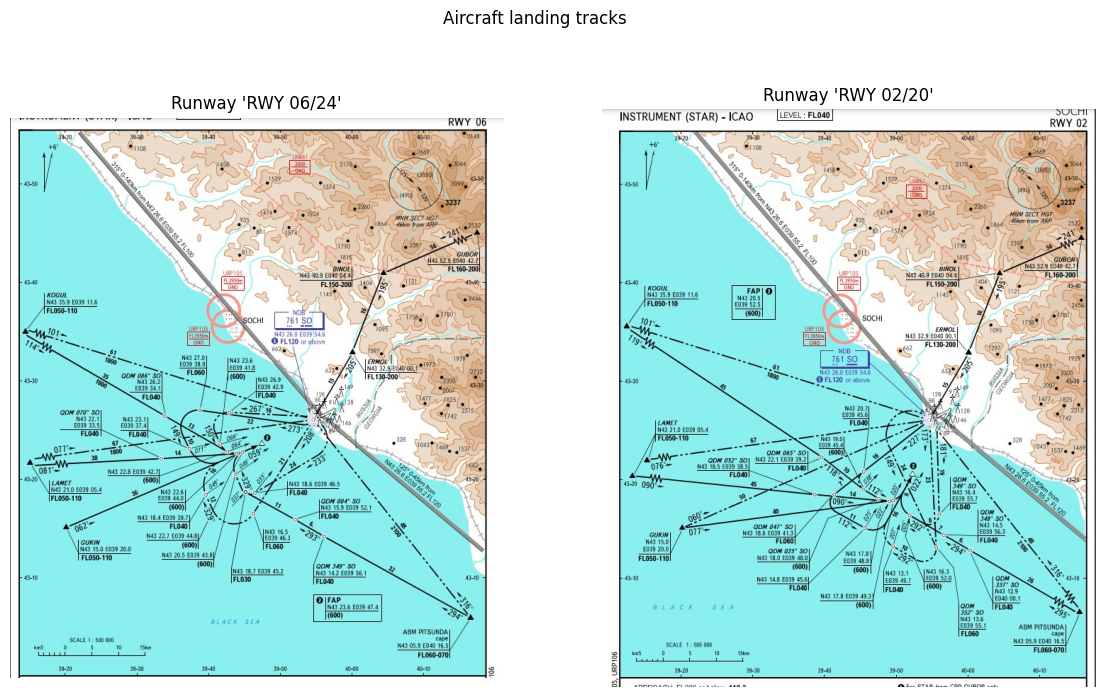

In [276]:
import matplotlib.image as mpimg
from matplotlib import rcParams

%matplotlib inline

# figure size in inches optional
rcParams['figure.figsize'] = 14 ,8

# read images
img_A = mpimg.imread('long_runway.jpg')
img_B = mpimg.imread('short_runway.jpg')

# display images
fig, ax = plt.subplots(1,2)
fig.suptitle("Aircraft landing tracks")
ax[0].set_title("Runway 'RWY 06/24'")
ax[1].set_title("Runway 'RWY 02/20'")
ax[0].axis('off')
ax[1].axis('off')
ax[0].imshow(img_A)
ax[1].imshow(img_B)
None

Определяем точки для прямой разделющей 2 траектории

In [277]:
#пара точек для определяющей прямой, разделяющий 2 траектории глиссад
y_1  = round(43.17/2 + 43.22/2, 3) #среднее между точками траекторий посадки для разных полос
x_1 = round(39.49/2 + 39.44/2, 3)

y_2 = round(sochi_airport.latitude, 3)
x_2 = round(sochi_airport.longitude, 3)
print(f"First point: {x_1},{y_1}")
print(f"Second point: {y_2},{x_2}")

# прямая y = kx + b
k = (y_1 - y_2)/(x_1 - x_2)
b = y_1 - k * x_1
k = round(k,3)
b = round(b,3)
print(f"line: y = {k}x + {b}")


First point: 39.465,43.195
Second point: 43.45,39.957
line: y = 0.518x + 22.741


Опрделяем полосу для конкретного рейса. Сначала учитывается особенности самолета. А потом траектория обрабатывается в зависимости от ее расположения к разделяющей прямой

In [278]:
def check_runway(list_of_flights):
    for flight in list_of_flights:
        first_runway = 'RWY 06/24'
        second_runway = 'RWY 02/20'
        # эти самолеты могут сесть только на первую полосу из-за длинны второй полосы
        if ("Airbus A380" in str(flight.aircraft_model)) or ("Boeing 747" in str(flight.aircraft_model)):
            flight.set_runway(first_runway)
            continue
        # считаем количество точек выше линии. Если все то первая полоса, если ни одной то вторая полоса
        count = 0
        for point in flight.points:
            if point.is_above_line(k, b):
                count += 1
        if count == flight.get_points_count():
            flight.set_runway(first_runway)
            continue
        if count == 0:
            flight.set_runway(second_runway)
            continue
        # по тому сколько раз пересек прямую и с какой стороны от прямой прилетел определяем полосу посадки
        for i in range(len(flight.points)-1):
            current_point = flight.points[i].is_above_line(k,b)
            next_point = flight.points[i+1].is_above_line(k,b)
            if (current_point ^ next_point) & current_point:
                flight.set_runway(second_runway)
                continue
            elif (current_point ^ next_point) & next_point:
                flight.set_runway(first_runway)


check_runway(arrival_flights)
check_runway(departure_flights)



Далее анализ собранных данных(в связи с отсутсвием сервера и возможности сбора на протяжении трех дней, сбор осуществлялся периодами: по ночам,промежутками ~ 3часов днем)

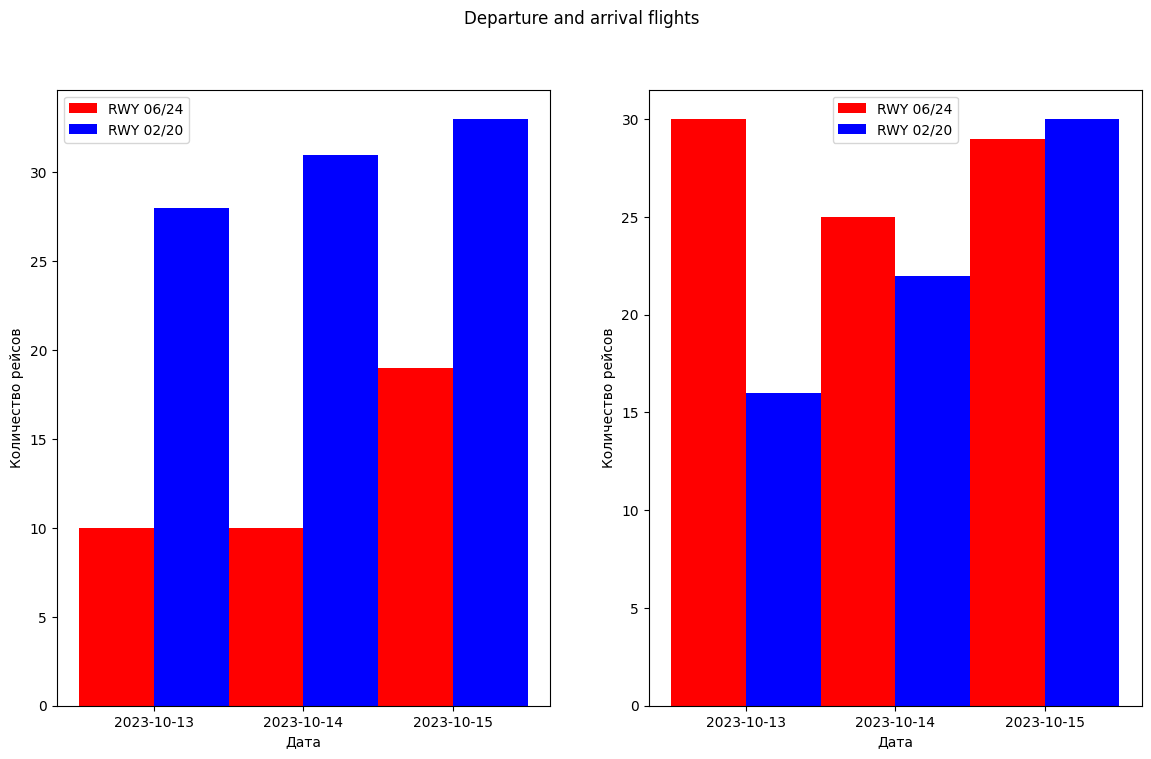

In [279]:
def get_point_for_display(flights):
    first_runway = 'RWY 06/24'
    second_runway = 'RWY 02/20'
    runway_day = ["2023-10-13", "2023-10-14", "2023-10-15"]
    first_runway_count = [0,0,0]
    second_runway_count = [0,0,0]
    for flight in flights:
        if flight.runway == first_runway:
            for i in range(len(runway_day)):
                if flight.date.day == runway_day[i]:
                    first_runway_count[i] +=1
        if flight.runway == second_runway:
            for i in range(len(runway_day)):
                if flight.date.day == runway_day[i]:
                    second_runway_count[i] +=1
    return [runway_day,first_runway_count,second_runway_count]

departure_display = get_point_for_display(departure_flights)
arrival_display = get_point_for_display(arrival_flights)

width_1 = 0.5
plt.subplot(1,2,1)
X_axis = np.arange(len(departure_display[0]))
plt.bar(X_axis - width_1/2,departure_display[1],color="red",width=width_1,label="RWY 06/24")
plt.bar(X_axis + width_1/2, departure_display[2],color = "blue",width=width_1,label="RWY 02/20")
plt.xlabel("Дата")
plt.ylabel("Количество рейсов")
plt.xticks(X_axis,departure_display[0])
plt.legend()
plt.suptitle("Departure and arrival flights")
plt.subplot(1,2,2)
plt.bar(X_axis - width_1/2,arrival_display[1],color="red",width=width_1,label="RWY 06/24")
plt.bar(X_axis + width_1/2,arrival_display[2],color="blue",width=width_1,label="RWY 02/20")
plt.xticks(X_axis,departure_display[0])
plt.xlabel("Дата")
plt.ylabel("Количество рейсов")
plt.legend()
plt.show()

Количество рейсов на каждую полосу в день

In [280]:
first_runway = 'RWY 06/24'
second_runway = 'RWY 02/20'


count_1 = 0
count_2 = 0
for flight in departure_flights:
    if flight.runway == first_runway:
        count_1 += 1
    if flight.runway == second_runway:
        count_2 += 1
print(f"Доля взлетов с полосы {first_runway}: {count_1}/{len(departure_flights)} = {round(count_1/len(departure_flights), 3)}")
print(f"Доля взлетов с полос {second_runway}: {count_2}/{len(departure_flights)} = {round(count_2/len(departure_flights), 3)}")

print()
count_1 = 0
count_2 = 0
for flight in arrival_flights:
    if flight.runway == first_runway:
        count_1 += 1
    if flight.runway == second_runway:
        count_2 += 1
print(f"Доля посадок на полосу {first_runway}: {count_1}/{len(arrival_flights)} = {round(count_1/len(arrival_flights), 3)}")
print(f"Доля посадок на полосу {second_runway}: {count_2}/{len(arrival_flights)} = {round(count_2/len(arrival_flights), 3)}")


Доля взлетов с полосы RWY 06/24: 39/131 = 0.298
Доля взлетов с полос RWY 02/20: 92/131 = 0.702

Доля посадок на полосу RWY 06/24: 84/152 = 0.553
Доля посадок на полосу RWY 02/20: 68/152 = 0.447
